# Applying NeuroProphet to the Ambulance Time Series

# imports

In [1]:
from neuralprophet import NeuralProphet, set_log_level
import pandas as pd
import numpy as np

# Disable logging messages unless there is an error
set_log_level("ERROR")

## Read in and pre-process data

In [2]:
url = 'https://raw.githubusercontent.com/TomMonks/swast-benchmarking/main/data/Daily_Responses_5_Years_2019_full.csv'

In [3]:
def pre_process_daily_data(path, index_col, by_col, 
                           values, dayfirst=False):
    '''
    Daily data is stored in long format.  Read in 
    and pivot to wide format so that there is a single 
    column for each regions time series.
    '''
    df = pd.read_csv(path, index_col=index_col, parse_dates=True, 
                     dayfirst=dayfirst)
    df.columns = map(str.lower, df.columns)
    df.index.rename(str(df.index.name).lower(), inplace=True)
    
    clean_table = pd.pivot_table(df, values=values.lower(), 
                                 index=[index_col.lower()],
                                 columns=[by_col.lower()], aggfunc=np.sum)
    
    clean_table.index.freq = 'D'
    
    return clean_table

In [4]:
def prophet_training_data(y_train):
    '''
    Converts a standard pandas datetimeindexed dataframe
    for time series into one suitable for Prophet
    Parameters:
    ---------
    y_train: pd.DataFrame
        univariate time series data
        
    Returns:
    --------
        pd.DataFrame in Prophet format 
        columns = ['ds', 'y']
    '''
    prophet_train = pd.DataFrame(y_train.index)
    prophet_train['y'] = y_train.to_numpy()
    prophet_train.columns = ['ds', 'y']

    return prophet_train

In [5]:
def new_years_day_events():

    df_events = pd.DataFrame(
        {
            "event": "new years day",
            "ds": pd.to_datetime(
                [
                    "2014-01-01",
                    "2015-01-01",
                    "2016-01-01",
                    "2017-01-01",
                    "2018-01-01",
                    "2019-01-01",
                    "2020-01-01",
                    "2021-01-01"
                ]
            ),
        }
    )

    return df_events

In [6]:
clean = pre_process_daily_data(url, 'Actual_dt', 'ORA', 'Actual_Value', 
                               dayfirst=False)
clean.head()

ora,BNSSG,Cornwall,Devon,Dorset,Gloucestershire,OOA,Somerset,Trust,Wiltshire
actual_dt,,,,,,,,,
2013-12-30,415.0,220.0,502.0,336.0,129.0,NaN,183.0,2042.0,255.0
2013-12-31,420.0,236.0,468.0,302.0,128.0,NaN,180.0,1996.0,260.0
2014-01-01,549.0,341.0,566.0,392.0,157.0,NaN,213.0,2570.0,351.0
2014-01-02,450.0,218.0,499.0,301.0,115.0,NaN,167.0,2013.0,258.0
2014-01-03,419.0,229.0,503.0,304.0,135.0,NaN,195.0,2056.0,269.0


In [7]:
clean.tail()

ora,BNSSG,Cornwall,Devon,Dorset,Gloucestershire,OOA,Somerset,Trust,Wiltshire
actual_dt,,,,,,,,,
2019-12-27,592.0,255.0,550.0,386.0,179.0,NaN,221.0,2552.0,369.0
2019-12-28,599.0,298.0,577.0,405.0,189.0,2.0,235.0,2655.0,350.0
2019-12-29,625.0,279.0,588.0,377.0,170.0,1.0,208.0,2613.0,365.0
2019-12-30,530.0,308.0,554.0,391.0,181.0,1.0,223.0,2498.0,310.0
2019-12-31,518.0,260.0,568.0,352.0,157.0,NaN,218.0,2387.0,314.0


## A `NeuralProphet` model trained on an individual time series with uncertainty limits 

In [18]:
# Load the data for the Ambulance service as a whole.
y_train = prophet_training_data(clean['Dorset'])
y_train.head()

,ds,y
0,2013-12-30,336.0
1,2013-12-31,302.0
2,2014-01-01,392.0
3,2014-01-02,301.0
4,2014-01-03,304.0


## Uncertainty quantification: quantile forecasts

We want to produce a model with prediction intervals.  We can do this in NeuralProphet using quantile regression.  I.e we will predict specific quantiles of a distribution as well the most likely value (point forecast).

Here we will produce an 95% prediction interval using the 0.025 and 0.975 quantiles.

In [19]:
quantile_list = [0.025, 0.975]

In [24]:
m = NeuralProphet(daily_seasonality=False,
                  quantiles=quantile_list)
m.set_plotting_backend("plotly")

nyd = new_years_day_events()
m.add_events("new years day")
y_train = m.create_df_with_events(y_train, nyd)

df_train, df_test = m.split_df(y_train, valid_p=0.33)
print(df_train.shape, df_test.shape)

metrics = m.fit(df_train, freq='D')

(1470, 3) (723, 3)


Finding best initial lr:   0%|          | 0/229 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

Predicting: 46it [00:00, ?it/s]

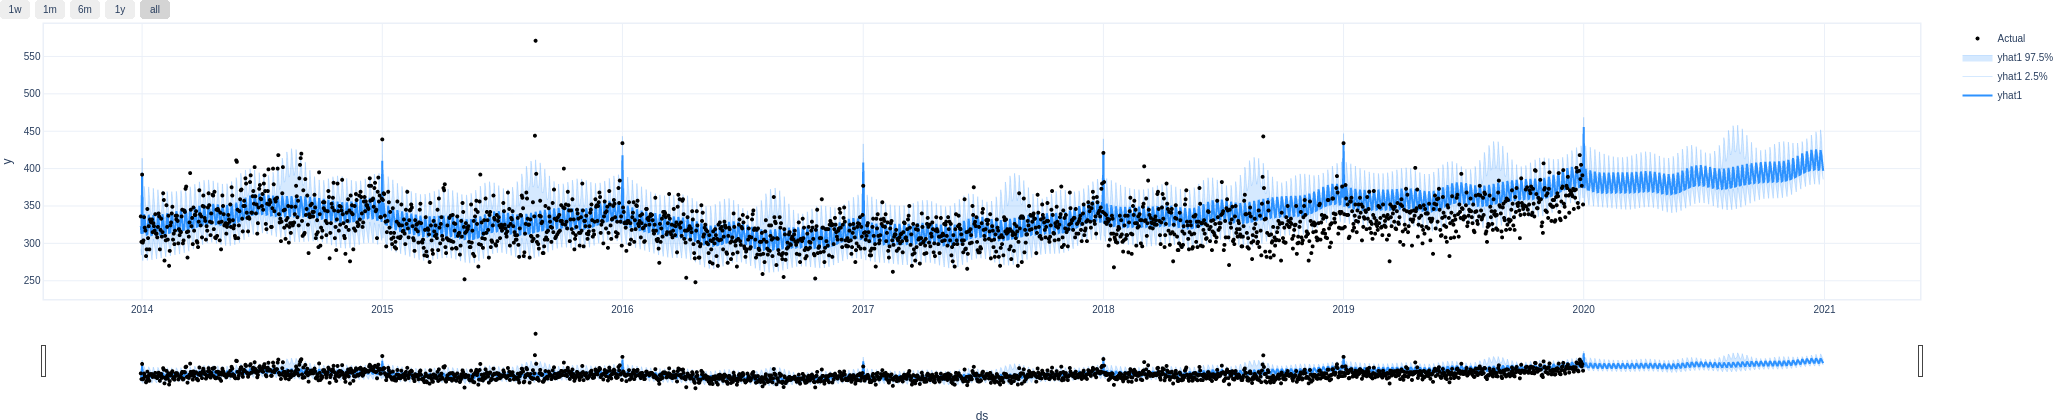

In [26]:
# Create a new dataframe reaching 365 into the future for our forecast
df_future = m.make_future_dataframe(y_train, events_df=nyd, 
                                    n_historic_predictions=True, periods=365)

# Predict the future
forecast = m.predict(df_future)

# Visualize the forecast
m.plot(forecast)

In [27]:
test_metrics = m.test(df_test)
test_metrics

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.031171413138508797
         MAE_val             22.29633140563965
        RMSE_val            26.775741577148438
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,22.296331,26.775742,0.031171,0.0


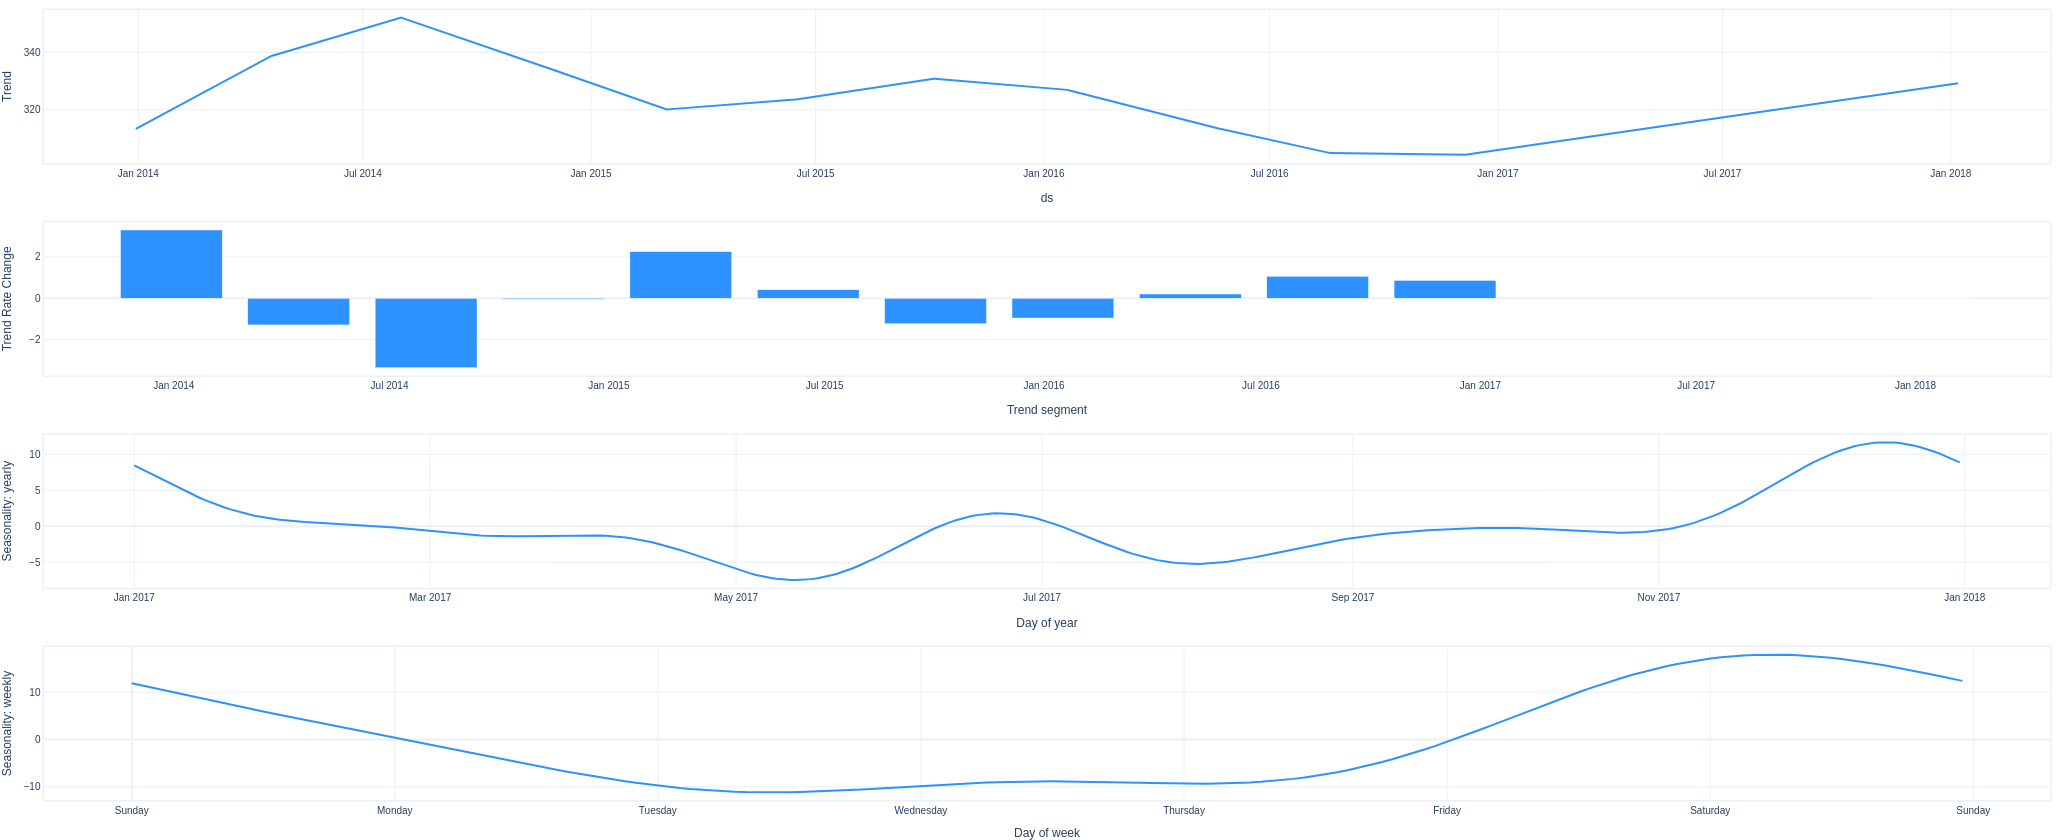

In [28]:
m.plot_parameters()

# Global Local Modelling

Our data is stored in tidy format and this turns out to be the correct format for `NeuralProphet` global models.  We just need to rename the columns.

In [29]:
df_global = pd.read_csv(url)
df_global.columns = ['ds', 'y', 'ID']
df_global.head()

,ds,y,ID
0,2013-12-30,220,Cornwall
1,2013-12-30,129,Gloucestershire
2,2013-12-30,255,Wiltshire
3,2013-12-30,2042,Trust
4,2013-12-30,336,Dorset


In [30]:
m2 = NeuralProphet(
    trend_global_local="local",
    season_global_local="local",
    epochs=50,
    daily_seasonality=False,
    quantiles = [0.025, 0.975]
)
m2.set_plotting_backend("plotly")

nyd = new_years_day_events()
m2.add_events("new years day")
df_global = m2.create_df_with_events(df_global, nyd)

In [ ]:
df

In [31]:
df_train, df_test = m2.split_df(df_global, valid_p=0.33, local_split=True)
print(df_train.shape, df_test.shape)

(11994, 4) (5898, 4)


In [32]:
metrics = m2.fit(df_train, freq="D")

Finding best initial lr:   0%|          | 0/252 [00:00<?, ?it/s]

Training: 0it [00:00, ?it/s]

In [33]:
future = m2.make_future_dataframe(df_test, n_historic_predictions=True)
forecast = m2.predict(future)

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

Predicting: 188it [00:00, ?it/s]

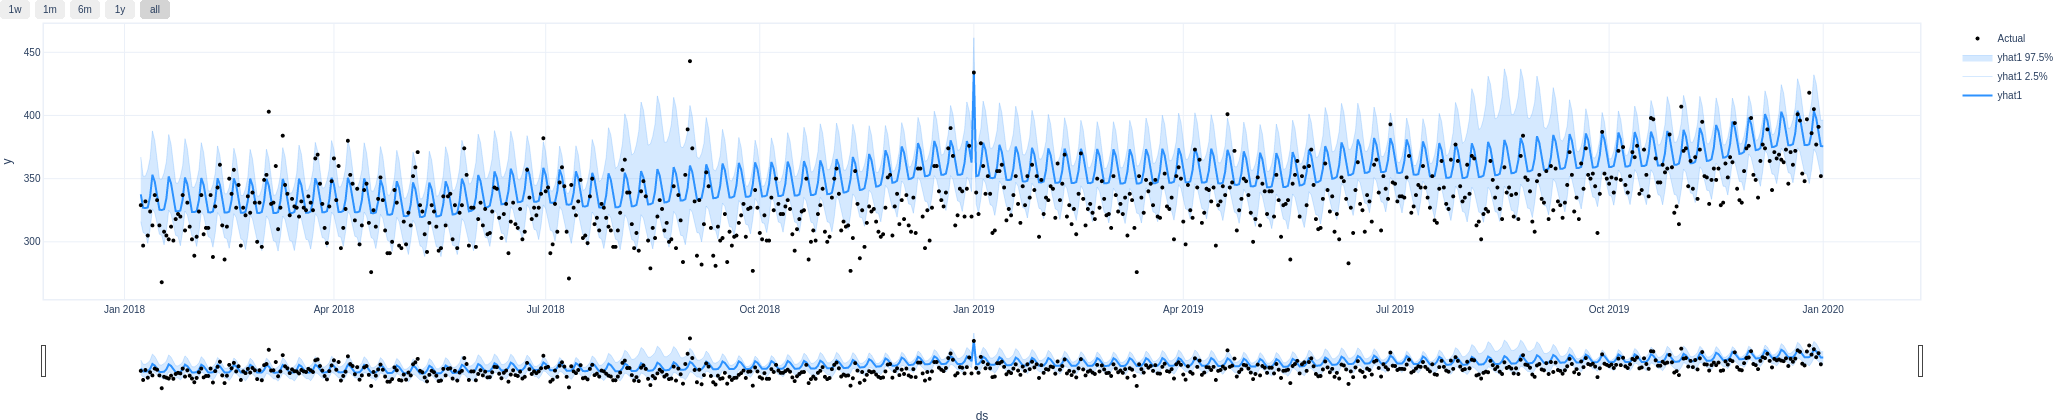

In [34]:
m2.plot(forecast[forecast["ID"] == "Dorset"])

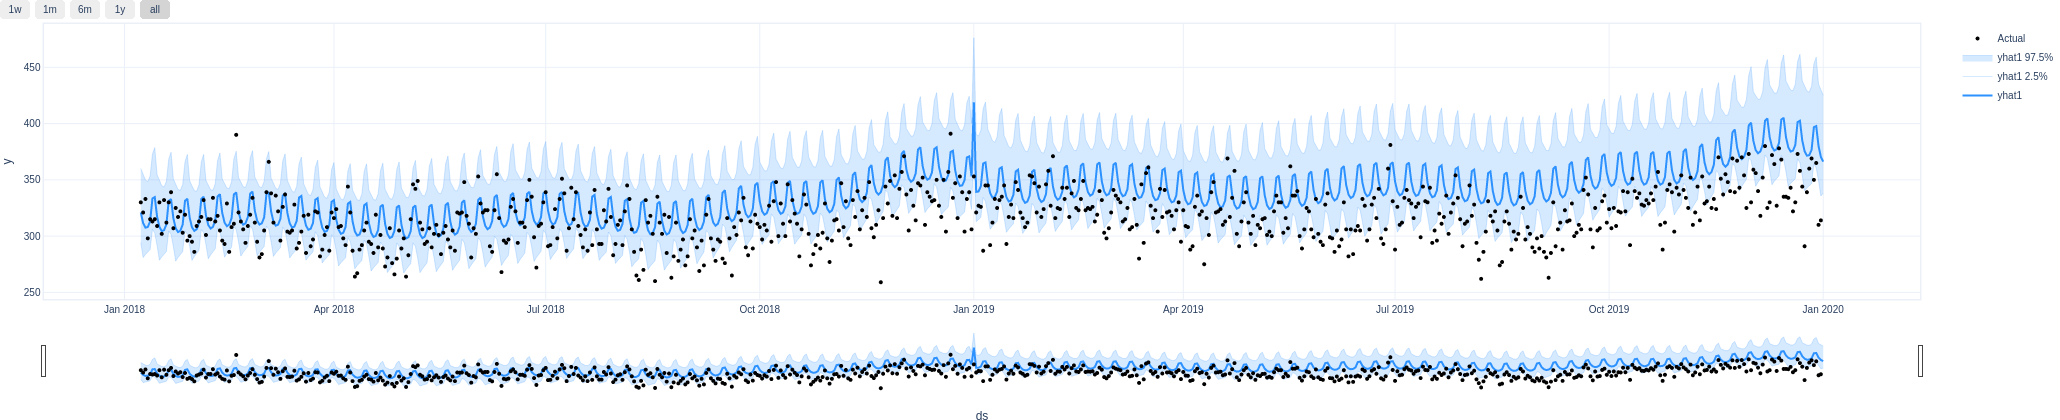

In [35]:
m2.plot(forecast[forecast["ID"] == "Wiltshire"])

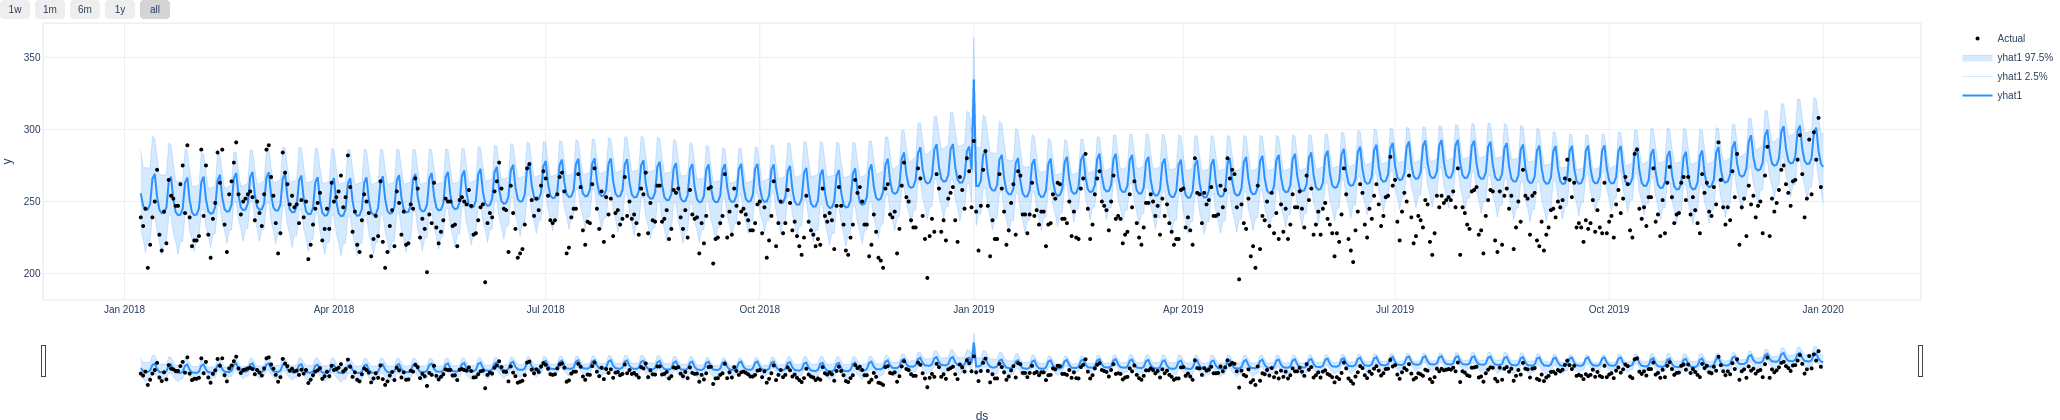

In [36]:
m2.plot(forecast[forecast["ID"] == "Cornwall"])

In [37]:
test_metrics_global = m2.test(df_test)
test_metrics_global



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Loss_test          0.052669625729322433
         MAE_val            0.22230708599090576
        RMSE_val            0.2697022259235382
      RegLoss_test                  0.0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


,MAE_val,RMSE_val,Loss_test,RegLoss_test
0,0.222307,0.269702,0.05267,0.0
